# Using Graphs to Work with Ontologies

## What is an ontology?

>a set of concepts and categories in a subject area or domain that shows their properties and the relations between them.

>In computer science and information science, an ontology is a formal naming and definition of the types, properties, and interrelationships of the entities that really exist in a particular domain of discourse. Thus, it is basically a taxonomy. It does not draw on the 'old' philosophical discipline 'ontology' as it was established in antiquity.
An ontology (in information science) compartmentalizes the variables needed for some set of computations and establishes the relationships between them.
>
The fields of artificial intelligence, the Semantic Web, systems engineering, software engineering, biomedical informatics, library science, enterprise bookmarking, and information architecture all create ontologies to limit complexity and organize information. The ontology can then be applied to problem solving. (Wikipedia ["Ontology (information science) (accessed 11/21/2017)"](https://goo.gl/W2PqYn))

## An Example

<img src="wilms_melanoma_carcinoid.png" alt="cancer ontology" width="400">


In [1]:
%matplotlib inline

In [2]:
import os
DATADIR = os.path.join("..","Resources")

import networkx as nx
from collections import defaultdict
from IPython.display import Image
import matplotlib.pyplot as plt
import re

In [3]:
r1 = re.compile(r"""pox""", re.I)
type(r1)

_sre.SRE_Pattern

# Ontologies and Graphs

* The most powerful way of specifying an ontology is with the [OWL](https://en.wikipedia.org/wiki/Web_Ontology_Language) language.
* A simpler format is [OBO flat file format](https://owlcollab.github.io/oboformat/doc/GO.format.obo-1_4.html)

### What does an OBO file look like?
#### Key concepts
* [Term] marks the beginning of a concept
* Each concept has a unique identifier (e.g. DOID:0001816), name (e.g. angiosarcoma), and other features
* **``is_a``**: this defines the hierarchical nature of the ontology. For example, an angiosarcoma **is a** sarcoma which **is a** cancer which **is a** disease.
    * **``is_a``** will define edges

~~~~~~~~~~~
[Term]
id: DOID:0001816
name: angiosarcoma
alt_id: DOID:267
alt_id: DOID:4508
def: "A malignant vascular tumor that results_in rapidly proliferating, extensively infiltrating anaplastic cells derived_from blood vessels and derived_from the lining of irregular blood-filled spaces." [url:http\://emedicine.medscape.com/article/276512-overview]
synonym: "Hemangioendothelioma, malignant (morphologic abnormality)" EXACT [SNOMEDCT_2005_07_31:33176006]
synonym: "hemangiosarcoma" EXACT []
synonym: "primary hemangiosarcoma" EXACT [NCI2004_11_17:C9275]
xref: MSH:D006394
xref: NCI:C3088
xref: SNOMEDCT_2010_1_31:33176006
xref: SNOMEDCT_2010_1_31:39000009
xref: SNOMEDCT_2010_1_31:403977003
xref: UMLS_CUI:C0018923
xref: UMLS_CUI:C0854893
is_a: DOID:1115 ! sarcoma


~~~~~~~~~~~~~~~~~~

* Nodes have labels (unique identifiers)
    * What would be the choice for a node label here?
* Lots more information (e.g., "xref","synonym")
    * Put these into node attributes. Just like a graph can have attributes nodes and edges can have attributes, all stored in dictionaries.
    
#### Note: I translate ":" to "->" becaues of some incompatibilities with the pygraphviz drawing package.

### An OBO Parser

* Reads an OBO file into a NetworkX graph

In [4]:
"""
    
based on 

http://techoverflow.net/blog/2013/11/18/a-geneontology-obo-v1.2-parser-in-python/

__author__    = "Uli Koehler"
__copyright__ = "Copyright 2013 Uli Koehler"
__license__   = "Apache v2.0"
"""

def addOBONode(graph,items):
    """
    In an object representing an OBO term, replace single-element lists with
    their only member.
    Returns the modified object as a dictionary.

    """
    ret = dict(items) #Input is a defaultdict, might express unexpected behaviour
    for key, value in ret.items():
        #key = key.replace(":","->")
        if len(value) == 1:
            ret[key] = value[0]
    _is = ret.pop('id').replace(":","->")

    try:
        _isa = ret.pop('is_a')
        if isinstance(_isa,str):
            _isa = [_isa]
    except KeyError:
        # this may be a root node
        if not ret.get('is_obsolete'):
            graph.graph["roots"].append(_is)
        _isa = []
    
    graph.add_node(_is,attr_dict=ret)
    if _isa:
        for isa in _isa:
            isa, sep, b = isa.partition("!")
            isa = isa.strip()
            
            graph.add_edge(isa.replace(":","->"),_is)
    
def parseOBO(filename):
    """
    Parses an OBO file
    """
    ontology = nx.DiGraph(roots=[])
    with open(filename,"rt") as fin:
        lines = fin.readlines()
    inTerm = False
    currentItems = defaultdict(list)
    while lines:
        
        line = lines.pop(0)
        line = line.strip()
        if not line: 
            continue #Skip empty
        if line == "[Term]":
            if inTerm:  
                addOBONode(ontology,currentItems)
                currentItems = defaultdict(list)
            else:
                inTerm = True
        elif line == "[Typedef]":
            #Skip [Typedef sections]
            currentItems = None
        else: #Not [Term]
            #Only process if we're inside a [Term] environment
            if currentItems is None: 
                continue
            key, sep, val = line.partition(":")
            currentItems[key].append(val.strip())
    #Add last term
    if currentItems is not None:
        addOBONode(ontology,currentItems) 
    return ontology

## Read in the [Human Disease Ontology](http://do-wiki.nubic.northwestern.edu/do-wiki/index.php/Main_Page)

In [5]:
ontology =  parseOBO(os.path.join(DATADIR,"doid.obo"))
   
print ("Found %d OBO terms" % len(ontology))

Found 9188 OBO terms


## What does the graph look like?

### Macro: to big to plot

### Micro: what does a node look like?
#### Each node has
* A label (the DOID)
* A dictionary of attributes

In [6]:
for key, value in ontology.node['DOID->635'].items():
    print(key)
    print(value)
    print()

subset
zoonotic_infectious_disease

name
acquired immunodeficiency syndrome

def
"A Human immunodeficiency virus infectious disease that results_in reduction in the numbers of CD4-bearing helper T cells below 200 per µL of blood or 14% of all lymphocytes thereby rendering the subject highly vulnerable to life-threatening infections and cancers, has_material_basis_in Human immunodeficiency virus 1 or has_material_basis_in Human immunodeficiency virus 2, which are transmitted_by sexual contact, transmitted_by transfer of blood, semen, vaginal fluid, pre-ejaculate, or breast milk, transmitted_by congenital method, and transmitted_by contaminated needles. Opportunistic infections are common in people with AIDS." [url:http\://en.wikipedia.org/wiki/AIDS, url:http\://www2.merriam-webster.com/cgi-bin/mwmednlm?book=Medical&va=aids]

synonym
['"acquired Immune deficiency" EXACT [NCI2004_11_17:C2851]', '"acquired immune deficiency syndrome" RELATED [SNOMEDCT_2005_07_31:186705005]', '"AIDS" EXACT 

### What does an edge look like?

* Edges are pair of nodes
* Edges also have a dictionary of attributes (which in our graph are all empty)

In [7]:
ontology.edge['DOID->769']

{'DOID->371': {}, 'DOID->4160': {}, 'DOID->4163': {}}

## Some functions for searching the graph

In [8]:
def hasNodeMatchingAttribute(g, attribute):
    """
    
    """
        
    matches = []
    for n in g.nodes(data=True):
        if attribute[1] in n[1].get(attribute[0]):
            matches.append((n[0], n[1]["name"]))
    return matches

In [9]:
hasNodeMatchingAttribute(ontology,['name','pox'])

[('DOID->2835', 'polycythemia due to hypoxia'),
 ('DOID->8659', 'chickenpox'),
 ('DOID->4369', 'brain hypoxia-Ischemia'),
 ('DOID->3295', 'fowlpox'),
 ('DOID->3292', 'monkeypox'),
 ('DOID->8956', 'cowpox'),
 ('DOID->11103', 'rickettsialpox'),
 ('DOID->10848', 'intrauterine hypoxia and birth asphyxia'),
 ('DOID->8736', 'smallpox')]

In [10]:
hasNodeMatchingAttribute(ontology,['name','acquired'])

[('DOID->621', 'simian acquired immunodeficiency syndrome'),
 ('DOID->11491', 'acquired night blindness'),
 ('DOID->12136', 'acquired coagulation factor deficiency'),
 ('DOID->11126', 'acquired thrombocytopenia'),
 ('DOID->10111',
  'Congenital or acquired abnormality of vagina, with delivery'),
 ('DOID->10059',
  'Congenital or acquired abnormality of vagina complicating pregnancy, childbirth, or the puerperium'),
 ('DOID->635', 'acquired immunodeficiency syndrome'),
 ('DOID->14099', 'acquired gastric outlet stenosis'),
 ('DOID->492', 'acquired hemangioma'),
 ('DOID->2834', 'acquired polycythemia'),
 ('DOID->12647', 'Congenital or acquired abnormality of vulva, with delivery'),
 ('DOID->4775', 'feline acquired immunodeficiency syndrome'),
 ('DOID->2069', 'vulvar acquired melanocytic nevus'),
 ('DOID->12135', 'acquired factor VIII deficiency'),
 ('DOID->13850', 'acquired hallux varus'),
 ('DOID->11421', 'acquired cavovarus foot deformity'),
 ('DOID->13912', 'acquired color blindness'),

In [11]:
hasNodeMatchingAttribute(ontology,['name','carcinoid'])

[('DOID->0050925', 'small intestine carcinoid neuroendocrine tumor'),
 ('DOID->8600', 'carcinoid syndrome'),
 ('DOID->0050911', 'appendix carcinoid tumor')]

In [12]:
def hasNodeWithAttribute(g,attribute):
    """
    """
    for n in g.nodes(data=True):
        if n[1].get(attribute[0]) == attribute[1]:
            return n[0]
    else:
        return None

### A function for returning the feature from a node

In [30]:
def getNodeFeature(graph,n,feature='name'):
    try:
        return graph.node[n][feature]
    except KeyError:
        return None

## Functions and Methods on Graphs

[Graph theory](https://en.wikipedia.org/wiki/Graph_theory) is a rich mathematical field and there are a lot of questions we can ask and answer about graphs. NetworkX provides a rich [set of tools](https://en.wikipedia.org/wiki/Graph_theory) (and [here](https://networkx.github.io/documentation/latest/reference/functions.html)) for answering many of these questions.

### How many edges and nodes are in the graph?

In [31]:
print (ontology.number_of_edges())
print (ontology.number_of_nodes())

7028
9188


### What is the [radius](http://mathworld.wolfram.com/GraphRadius.html) of the graph?

In [32]:
print(nx.radius(ontology))

NetworkXError: Graph not connected: infinite path length

### What does it mean to have an infinite radius?

### What are the degrees of the nodes?

In [ ]:
degrees = nx.degree_histogram(ontology)
plt.bar(range(0,len(degrees)),degrees)
plt.xlabel("degree")
plt.ylabel("count")

### What are all these zero degree nodes?

In [ ]:
zero_degree_nodes = [getNodeFeature(ontology,n[0]) for n in ontology.nodes(data=True) if ontology.degree(n[0])==0]
print(len(zero_degree_nodes))

### We could also use the `isolates` function

In [ ]:
len(nx.isolates(ontology))

In [ ]:
zero_degree_nodes

## Challenge: What is the most important node?

* "Important": node with the largest degree

In [23]:
highest = 0
for node in ontology.node:
    degree = ontology.degree(node)
    if degree > highest:
        highest = degree
print(highest)

82


## Drawing Graphs

NetworkX has some built-in functions for drawing graphs with Matplotlib. In general they don't work very well. Here is a function to do a (hopefully) better drawing of a graph.

In [24]:
def be_copy(g):
    return nx.DiGraph([(e[0],e[1]) for e in g.edges()])
def drawOBOGraph(graph,feature='name'):

    labels = {}
    for n in graph.nodes(data=True):
        labels[n[0]] = n[1][feature]
    nx.draw_networkx_edges(graph,
                           pos=nx.nx_pydot.graphviz_layout(
                                be_copy(graph),
                                prog='dot',
                                root=graph.graph['roots'][0]))
    nx.draw_networkx_nodes(graph,alpha=0.25,
                           pos=nx.nx_pydot.graphviz_layout(
                                be_copy(graph),
                                prog='dot',
                                root=graph.graph['roots'][0]))
    nx.draw_networkx_labels(graph,
                            pos=nx.nx_pydot.graphviz_layout(
                                be_copy(graph),
                                prog='dot', font_size=18,
                                root=graph.graph['roots'][0]),
                            labels=labels)
    

## Can we extract useful subgraphs?

* Algorithms for optimal paths through graphs is an important topic. Here we use a well-known shortest path algorithm ([Dijkstra Algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)) to find the shortest path from the target to the graph root. We then use the subgraph method to create a graph consisting of the nodes of the shortest path.

In [25]:
def getPathSubGraph(graph,root,target):
    path = nx.dijkstra_path(graph,root,target)
    subGraph = graph.subgraph(path)
    return subGraph
    

In [26]:
def getDescendantGraph(graph,root):
    descendantNodes = nx.descendants(graph,root)
    descendantGraph = graph.subgraph(descendantNodes)
    return descendantGraph

### A function to print out the path between two nodes

In [27]:
def namedTraverse(graph,root, target):
    
        path = nx.dijkstra_path(graph,root,target)
        path.reverse()
        tabdepth = ""
        for p in path[:-1]:
            print (tabdepth+"'%s' which is a"%graph.node[p]['name'])
            tabdepth += " "
        print (tabdepth+"'%s'"%graph.node[path[-1]]['name'])



### Find Nearest Common Ancestor to Two Nodes

In [33]:
def findLowestCommonAncestor(graph,node1,node2):
    try:
        path1 = nx.dijkstra_path(graph,graph.graph['roots'][0],node1)
        path2 = nx.dijkstra_path(graph,graph.graph['roots'][0],node2)
        if len(path2) < len(path1):
            spath= path2
            lpath=path1
        else:
            spath = path1
            lpath = path2
        lpath.reverse()
        for np in lpath:
            if np in spath:
                return np
    except nx.NetworkXNoPath:
        return None


In [34]:
cnode= findLowestCommonAncestor(ontology,
                         hasNodeWithAttribute(ontology,['name','sarcoma']),
                         hasNodeWithAttribute(ontology,['name','smallpox']))
if cnode:
    print (getNodeFeature(ontology,cnode))

disease


In [35]:
cnode= findLowestCommonAncestor(ontology,
                         hasNodeWithAttribute(ontology,['name','aids']),
                         hasNodeWithAttribute(ontology,['name','smallpox']))
if cnode:
    print (getNodeFeature(ontology,cnode))

In [36]:
def getGraphRoot(graph,root=0):
    return graph.graph['roots'][root]

In [37]:
namedTraverse(ontology,getGraphRoot(ontology),
              hasNodeWithAttribute(ontology,['name','sarcoma']))

'sarcoma' which is a
 'cell type cancer' which is a
  'cancer' which is a
   'disease of cellular proliferation' which is a
    'disease'


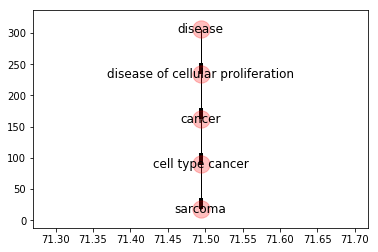

In [38]:
drawOBOGraph(getPathSubGraph(ontology,ontology.graph['roots'][0],hasNodeWithAttribute(ontology,['name','sarcoma'])))

## Challenge: What nodes have the longest shortest path to the graph root ("disease")

In [40]:
longest = 0
for node in ontology.node:
    path = single_source.dijkstra_path_length(ontology.graph,ontology.graph['roots'][0],hasNodeWithAttribute(ontology,['name','disease']),node)
    print(path)
    if degree > highest:
        highest = degree
print(highest)

['DOID->4']


NameError: name 'degree' is not defined

## Can we make better visualizations?

NetworkX can interface with the GraphViz package from AT&T. This is not necessarily easy to install, particularly on Windows. 


In [ ]:
def getOBO_pydot(graph,feature='name'):
    newGraph = nx.DiGraph()
    for e in graph.edges():
        newGraph.add_edge(graph.node[e[1]][feature],graph.node[e[0]][feature])
    ag = nx.nx_pydot.to_pydot(newGraph)
    return ag

In [ ]:
ag = getOBO_pydot(getPathSubGraph(ontology,
                                  ontology.graph['roots'][0],
                                  'DOID->1115'))

ag.write_png(os.path.join(DATADIR,
                          "%s.png"%getNodeFeature(ontology,
                                                  'DOID->1115')))

# This is a way of displaying images in an IPython notebook (see import at top)
# cannot display PDF files this way
Image(filename=(os.path.join(DATADIR,
                             "%s.png"%getNodeFeature(ontology,
                                                     'DOID->1115'))))

### How did I generate the illustrative visualization used above?

* This makes use of the `nx.compose` function that creates a new graph by merging two existing graphs

In [ ]:
nx.compose_all?

In [ ]:
#g1 = getPathSubGraph(ontology, ontology.graph['roots'][0],'DOID->0060080')

g1 = getPathSubGraph(ontology, ontology.graph['roots'][0],hasNodeWithAttribute(ontology,['name','appendix carcinoid tumor']))
g2 = getPathSubGraph(ontology, ontology.graph['roots'][0],'DOID->5176')
g3 = getPathSubGraph(ontology, ontology.graph['roots'][0],hasNodeWithAttribute(ontology,['name','melanoma']))
ag = getOBO_pydot(nx.compose_all((g1, g2, g3)))

ag.write_png("wilms_melanoma_carcinoid.png")

# This is a way of displaying images in an IPython notebook (see import at top)
# cannot display PDF files this way
print(hasNodeWithAttribute(ontology,['name',"""melanoma"""]))

Image(filename="wilms_melanoma_carcinoid.png")

In [ ]:
nid =hasNodeWithAttribute(ontology,['name',
                                    """fallopian tube adenosarcoma"""])
ag = getOBO_pydot(getPathSubGraph(ontology,getGraphRoot(ontology),nid))
ag.write_png(os.path.join(DATADIR,"temp.png"))

Image(filename=(os.path.join(DATADIR,"temp.png")))